In [4]:
import tensorflow as tf
import numpy as np
from google.colab import drive
from sklearn.model_selection import train_test_split
# import data
drive.mount('/content/drive')
with open('/content/drive/My Drive/ECE539/projectfinal/data.csv', 'r') as f: 
  data = np.genfromtxt(f, dtype='f4', delimiter=',')
samplenum = 5000
X = data[:samplenum,:-1]
y = data[:samplenum,-1]
print('# of samples = ', samplenum)
# partition into train, validate, test set at 60/20/20 division
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)
TSSytest = np.sum((y_test - np.mean(y_test))**2)
nytest = len(y_test)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
# of samples =  5000


Performance test between the RELU and softplus for different units.

In [16]:
units = np.array([5, 10, 15, 20, 25, 30])
MSError_relu = np.zeros(6)
AdjustedR2_relu = np.zeros(6)
for index, i in enumerate(units):
  net = tf.keras.models.Sequential([
    tf.keras.layers.Normalization(),
    tf.keras.layers.Dense(i, input_dim=X.shape[1], activation = 'relu'),
    tf.keras.layers.Dense(i, activation = 'relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
  net.compile(loss='MeanSquaredError', optimizer='adam', metrics=['MeanSquaredError'])
  history = net.fit(X_train, y_train, epochs=50, verbose=0, batch_size=50, validation_data=(X_val,y_val))
  MSError_relu[index] = net.evaluate(X_test, y_test,verbose=0)[0]
  AdjustedR2_relu[index] = 1 - (MSError_relu[index]*nytest/(nytest-X.shape[1]-1))/(TSSytest/(nytest-1))

In [17]:
MSError_softplus = np.zeros(6)
AdjustedR2_softplus = np.zeros(6)
for index, i in enumerate(units):
  net = tf.keras.models.Sequential([
    tf.keras.layers.Normalization(),
    tf.keras.layers.Dense(i, input_dim=X.shape[1], activation = 'softplus'),
    tf.keras.layers.Dense(i, activation = 'softplus'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
  net.compile(loss='MeanSquaredError', optimizer='adam', metrics=['MeanSquaredError'])
  history = net.fit(X_train, y_train, epochs=50, verbose=0, batch_size=50, validation_data=(X_val,y_val))
  MSError_softplus[index] = net.evaluate(X_test, y_test,verbose=0)[0]
  AdjustedR2_softplus[index] = 1 - (MSError_softplus[index]*nytest/(nytest-X.shape[1]-1))/(TSSytest/(nytest-1))

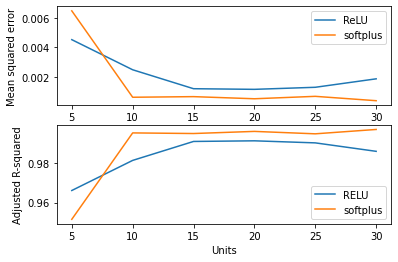

In [22]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1)
axs[0].plot(units, MSError_relu , label='ReLU')
axs[0].plot(units, MSError_softplus , label='softplus')
axs[0].set_xlabel('Units')
axs[0].set_ylabel('Mean squared error')
axs[0].legend()

axs[1].plot(units, AdjustedR2_relu, label='RELU')
axs[1].plot(units, AdjustedR2_softplus , label='softplus')
axs[1].set_xlabel('Units')
axs[1].set_ylabel('Adjusted R-squared')
axs[1].legend()

Performance test at different epochs 

In [38]:
net = tf.keras.models.Sequential([
  tf.keras.layers.Normalization(),
  tf.keras.layers.Dense(10, input_dim=X.shape[1], activation = 'softplus'),
  tf.keras.layers.Dense(10, activation = 'softplus'),
  tf.keras.layers.Dense(1, activation='sigmoid')
  ])
net.compile(loss='MeanSquaredError', optimizer='adam', metrics=['MeanSquaredError'])
history = net.fit(X_train, y_train, epochs=100, verbose=0, batch_size=50, validation_data=(X_val,y_val))

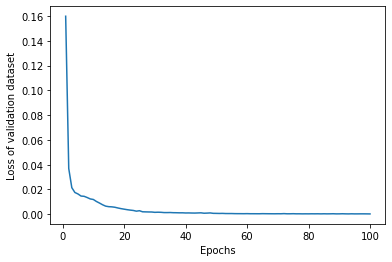

In [39]:
plt.figure()
plt.plot(range(1,101), history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss of validation dataset')
plt.show()

Performance test for different batch sizes

In [53]:
batchsizes = np.array([10,20,50,100,200,500,1000])

In [54]:
MSError = np.zeros(len(batchsizes))
AdjustedR2 = np.zeros(len(batchsizes))
for index, batchsize in enumerate(batchsizes):
  net = tf.keras.models.Sequential([
    tf.keras.layers.Normalization(),
    tf.keras.layers.Dense(10, input_dim=X.shape[1], activation = 'softplus'),
    tf.keras.layers.Dense(10, activation = 'softplus'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
  net.compile(loss='MeanSquaredError', optimizer='adam', metrics=['MeanSquaredError'])
  history = net.fit(X_train, y_train, epochs=50, verbose=0, batch_size=batchsize, validation_data=(X_val,y_val))
  MSError[index] = net.evaluate(X_test, y_test,verbose=0)[0]
  AdjustedR2[index] = 1 - (MSError[index]*nytest/(nytest-X.shape[1]-1))/(TSSytest/(nytest-1))

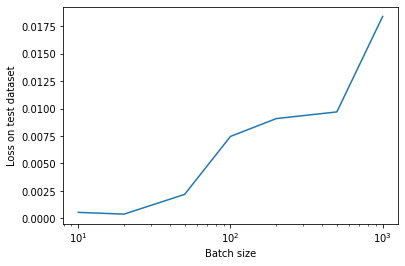

In [56]:
plt.figure()
plt.plot(batchsizes, MSError)
plt.xlabel('Batch size')
plt.ylabel('Loss on test dataset')
plt.xscale('log')
plt.show()

Forward stepwise selection

In [57]:
MSError_F = np.ones((X.shape[1],X.shape[1]))*np.inf
AdjustedR2_F = np.zeros((X.shape[1],X.shape[1]))

for num in range(X.shape[1]):
  # print('Now selecting the #',num,'significant feature.')
  for nextfeature in range(X.shape[1]):
    if nextfeature in np.argmin(MSError_F[:num,:],axis=1):
      continue
    net = tf.keras.models.Sequential([
      tf.keras.layers.Normalization(),
      tf.keras.layers.Dense(10, input_dim=num+1, activation = 'softplus'),
      tf.keras.layers.Dense(10, activation = 'softplus'),
      tf.keras.layers.Dense(1, activation='sigmoid')
      ])
    net.compile(loss='MeanSquaredError', optimizer='adam', metrics=['MeanSquaredError'])
    feature = np.append(np.argmin(MSError_F[:num,:],axis=1),nextfeature)
    history = net.fit(X_train[:,feature], y_train, epochs=50, verbose=0, batch_size=20, validation_data=(X_val[:,feature],y_val))
    MSError_F[num,nextfeature] = net.evaluate(X_test[:,feature], y_test,verbose=0)[0]
    # print('Feature', feature, '. MSError = ', MSError_F[num,nextfeature])
    AdjustedR2_F[num,nextfeature] = 1 - (MSError_F[num,nextfeature]*nytest/(nytest-(num+1)-1))/(TSSytest/(nytest-1))
  print('Feature', np.argmin(MSError_F[:num+1,:],axis=1),
        'MSE =', MSError_F[num,np.argmin(MSError_F[num,:])],
        'Adjusted R2 =', AdjustedR2_F[num,np.argmin(MSError_F[num,:])])

Feature [2] MSE = 0.045251812785863876 Adjusted R2 = 0.6643344349957424
Feature [2 0] MSE = 0.0016807373613119125 Adjusted R2 = 0.9875202453893585
Feature [2 0 1] MSE = 0.0007861943449825048 Adjusted R2 = 0.9941565150844532
Feature [2 0 1 8] MSE = 0.0003651450388133526 Adjusted R2 = 0.997283287546319
Feature [ 2  0  1  8 10] MSE = 0.00037847989005967975 Adjusted R2 = 0.9971812421120818
Feature [ 2  0  1  8 10  5] MSE = 0.0003611741994973272 Adjusted R2 = 0.9973074187300051
Feature [ 2  0  1  8 10  5  9] MSE = 0.00032685542828403413 Adjusted R2 = 0.9975608114098898
Feature [ 2  0  1  8 10  5  9  4] MSE = 0.00038439934724010527 Adjusted R2 = 0.997128489973372
Feature [ 2  0  1  8 10  5  9  4  7] MSE = 0.000390618690289557 Adjusted R2 = 0.9970790832782201
Feature [ 2  0  1  8 10  5  9  4  7  3] MSE = 0.0006344024441204965 Adjusted R2 = 0.9952513527890409
Feature [ 2  0  1  8 10  5  9  4  7  3  6] MSE = 0.0007545322296209633 Adjusted R2 = 0.9943464374598736


Backwise stepwise selection

In [58]:
MSError_B = np.ones((X.shape[1],X.shape[1]))*np.inf
AdjustedR2_B = np.zeros((X.shape[1],X.shape[1]))

for num in range(X.shape[1]-1):
  # print('Now selecting the #',num,'least significant feature.')
  for nextfeature in range(X.shape[1]):
    if nextfeature in np.argmin(MSError_B[:num,:],axis=1):
      continue
    net = tf.keras.models.Sequential([
      tf.keras.layers.Normalization(),
      tf.keras.layers.Dense(10, input_dim=X.shape[1]-num-1, activation = 'softplus'),
      tf.keras.layers.Dense(10, activation = 'softplus'),
      tf.keras.layers.Dense(1, activation='sigmoid')
      ])
    net.compile(loss='MeanSquaredError', optimizer='adam', metrics=['MeanSquaredError'])
    feature = np.array(list(set(range(X.shape[1]))-set(np.append(np.argmin(MSError_B[:num,:],axis=1),nextfeature))))
    history = net.fit(X_train[:,feature], y_train, epochs=50, verbose=0, batch_size=20, validation_data=(X_val[:,feature],y_val))
    MSError_B[num,nextfeature] = net.evaluate(X_test[:,feature], y_test,verbose=0)[0]
    # print('Feature', feature, '. MSError = ', MSError_B[num,nextfeature])
    AdjustedR2_B[num,nextfeature] = 1 - (MSError_B[num,nextfeature]*nytest/(nytest-(num+1)-1))/(TSSytest/(nytest-1))
  print('Feature', np.argmin(MSError_B[:num+1,:],axis=1),
        'MSE = ', MSError_B[num,np.argmin(MSError_B[num,:])],
        'Adjusted R2 =', AdjustedR2_B[num,np.argmin(MSError_B[num,:])])

Feature [3] MSE =  0.0003526184300426394 Adjusted R2 = 0.9973843729728292
Feature [3 6] MSE =  0.0004356931312941015 Adjusted R2 = 0.9967649059934931
Feature [3 6 5] MSE =  0.000381690013455227 Adjusted R2 = 0.9971630426366268
Feature [ 3  6  5 10] MSE =  0.00028618425130844116 Adjusted R2 = 0.9978707630203503
Feature [ 3  6  5 10  4] MSE =  0.0003958032466471195 Adjusted R2 = 0.9970522250908119
Feature [ 3  6  5 10  4  8] MSE =  0.00029102343250997365 Adjusted R2 = 0.9978303980611112
Feature [ 3  6  5 10  4  8  1] MSE =  0.00041841750498861074 Adjusted R2 = 0.9968775210207501
Feature [ 3  6  5 10  4  8  1  9] MSE =  0.0008978143450804055 Adjusted R2 = 0.9932932172948294
Feature [ 3  6  5 10  4  8  1  9  7] MSE =  0.00196855328977108 Adjusted R2 = 0.9852798128590702
Feature [ 3  6  5 10  4  8  1  9  7  0] MSE =  0.045780692249536514 Adjusted R2 = 0.6573210608166435


In [59]:
back1 = np.array(list(set(range(X.shape[1]))-set(np.argmin(MSError_B[:-1,:],axis=1))))
for num in range(1,X.shape[1]):
  print(num,'predictor(s)')
  print('Forward:',np.argmin(MSError_F[:num,:],axis=1))
  print('Backward:',np.concatenate((back1,np.flip(np.argmin(MSError_B[X.shape[1]-num:-1,:],axis=1)))))

1 predictor(s)
Forward: [2]
Backward: [2]
2 predictor(s)
Forward: [2 0]
Backward: [2 0]
3 predictor(s)
Forward: [2 0 1]
Backward: [2 0 7]
4 predictor(s)
Forward: [2 0 1 8]
Backward: [2 0 7 9]
5 predictor(s)
Forward: [ 2  0  1  8 10]
Backward: [2 0 7 9 1]
6 predictor(s)
Forward: [ 2  0  1  8 10  5]
Backward: [2 0 7 9 1 8]
7 predictor(s)
Forward: [ 2  0  1  8 10  5  9]
Backward: [2 0 7 9 1 8 4]
8 predictor(s)
Forward: [ 2  0  1  8 10  5  9  4]
Backward: [ 2  0  7  9  1  8  4 10]
9 predictor(s)
Forward: [ 2  0  1  8 10  5  9  4  7]
Backward: [ 2  0  7  9  1  8  4 10  5]
10 predictor(s)
Forward: [ 2  0  1  8 10  5  9  4  7  3]
Backward: [ 2  0  7  9  1  8  4 10  5  6]


In [70]:
net = tf.keras.models.Sequential([
  tf.keras.layers.Normalization(),
  tf.keras.layers.Dense(10, input_dim=X.shape[1], activation = 'softplus'),
  tf.keras.layers.Dense(10, activation = 'softplus'),
  tf.keras.layers.Dense(1, activation='sigmoid')
  ])
net.compile(loss='MeanSquaredError', optimizer='adam', metrics=['MeanSquaredError'])
history = net.fit(X_train, y_train, epochs=50, verbose=0, batch_size=20, validation_data=(X_val,y_val))
MSError_full = net.evaluate(X_test, y_test,verbose=0)[0]
AdjustedR2_full = 1 - (MSError_full*nytest/(nytest-X.shape[1]-1))/(TSSytest/(nytest-1))

Compare two forward and backward stepwise

Plot mean squared error and adjusted R-squared versus number of predictors.

In [71]:
MAMA = np.zeros((4,X.shape[1]))
for num in range(X.shape[1]-1):
  MAMA[0,num] = MSError_F[num,np.argmin(MSError_F[num,:])]
  MAMA[1,num] = AdjustedR2_F[num,np.argmin(MSError_F[num,:])]
  MAMA[2,num] = MSError_B[X.shape[1]-2-num,np.argmin(MSError_B[X.shape[1]-2-num,:])]
  MAMA[3,num] = AdjustedR2_B[X.shape[1]-2-num,np.argmin(MSError_B[X.shape[1]-2-num,:])]
MAMA[0,-1] = MSError_full
MAMA[1,-1] = AdjustedR2_full
MAMA[2,-1] = MSError_full
MAMA[3,-1] = AdjustedR2_full

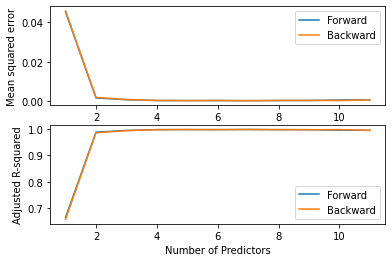

In [72]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1)
axs[0].plot(list(range(1,X.shape[1]+1)), MAMA[0], label='Forward')
axs[0].plot(list(range(1,X.shape[1]+1)), MAMA[2], label='Backward')
axs[0].set_xlabel('Number of Predictors')
axs[0].set_ylabel('Mean squared error')
axs[0].legend()

axs[1].plot(list(range(1,X.shape[1]+1)), MAMA[1], label='Forward')
axs[1].plot(list(range(1,X.shape[1]+1)), MAMA[3], label='Backward')
axs[1].set_xlabel('Number of Predictors')
axs[1].set_ylabel('Adjusted R-squared')
axs[1].legend()

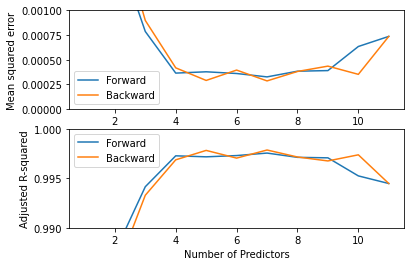

In [73]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(list(range(1,X.shape[1]+1)), MAMA[0], label='Forward')
axs[0].plot(list(range(1,X.shape[1]+1)), MAMA[2], label='Backward')
axs[0].set_xlabel('Number of Predictors')
axs[0].set_ylabel('Mean squared error')
axs[0].set_ylim(0,0.001)
axs[0].legend()

axs[1].plot(list(range(1,X.shape[1]+1)), MAMA[1], label='Forward')
axs[1].plot(list(range(1,X.shape[1]+1)), MAMA[3], label='Backward')
axs[1].set_xlabel('Number of Predictors')
axs[1].set_ylabel('Adjusted R-squared')
axs[1].set_ylim(0.99,1)
axs[1].legend()

For small number of predictors, the forward stepwise selection has better performance than the backward stepwise selection, with smaller mean squared error and larger adjusted R-squared.

In [75]:
print('In the forward stepwise selection,',np.argmax(MAMA[1,:])+1,
      'predictors lead to largest value of adjusted R-squared, which is',MAMA[1,np.argmax(MAMA[1,:])])
print('The features are',np.argmin(MSError_F[:np.argmax(MAMA[1,:])+1,:],axis=1))

In the forward stepwise selection, 7 predictors lead to largest value of adjusted R-squared, which is 0.9975608114098898
The features are [ 2  0  1  8 10  5  9]
